In [1]:
import numpy as np
import torch
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import os
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [3]:
# data_path = '/content/drive/My Drive/' 
data_path = '/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [5]:
tresh = 127
filename = "Uniform_3_0.mat" 
# filename =  'Normal_1_0.5.mat' #'Mono_2_0.5.mat'
data3d = (loadmat(data_path+filename)["ctImage"] > tresh).astype(np.float)
#bwImage = rawMatData["bwImage"]
# ctImage = rawMatData["ctImage"]

SKIP = 4
sublattice = [slice(None,512,SKIP)]*3

data3d = torch.tensor(data3d[sublattice]).to(device)

<ipython-input-5-88004aee8c00>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data3d = torch.tensor(data3d[sublattice]).to(device)


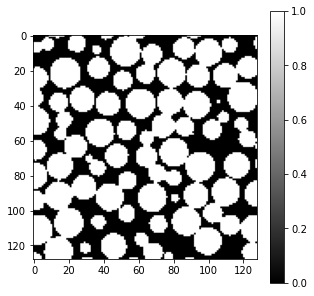

In [6]:
selection = (slice(None), 13, slice(None))

plt.figure(figsize=(5,5))
plt.imshow(data3d[selection].cpu(),  cmap='gray')
plt.colorbar();

In [8]:
from ipypb import ipb
tqdm_notebook = ipb
import time

In [9]:
from torch.utils.data import Dataset, DataLoader

class discreteDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [10]:
import edt
def sdf(dat):
    dat = dat.astype(dtype=np.float32)
    return edt.edt(dat) - edt.edt(1.-dat)

def tsdf(dat, mu=3):
    return sdf(dat).clip(-mu, mu)

In [11]:
MODE = '2D'
if MODE =='3D':
    data_sdf = sdf(data3d.cpu().numpy())
    dat = torch.tensor(data_sdf[selection]).to(device)
else:
    dat = torch.tensor(sdf(data3d[selection].cpu().numpy())).to(device)

In [12]:
## Looking at Fourier harmonics

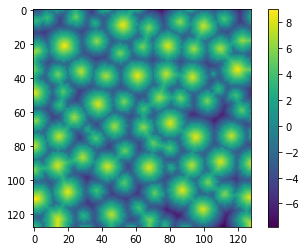

In [13]:
# plt.figure(figsize=(12,12))
plt.imshow(dat.cpu(), cmap='viridis')
# plt.contour(dat, levels=[0], colors=['yellow'])
plt.colorbar()

In [14]:
import scipy

In [15]:
def roll(arr):
    Nx, Ny = arr.shape
    arr = np.roll(arr, axis=0, shift=Nx//2) 
    arr = np.roll(arr, axis=1, shift=Ny//2) 
    return arr

def unroll(arr):
    Nx, Ny = arr.shape
    arr = np.roll(arr, axis=0, shift=-Nx//2) 
    arr = np.roll(arr, axis=1, shift=-Ny//2) 
    return arr

dat_fft = roll(scipy.fft.fftn(dat.cpu().numpy()))

In [16]:
dr, di = np.real(dat_fft), np.imag(dat_fft)

In [17]:
def two_plots(a, b, cmap='viridis', titles=None):
    fig, axs = plt.subplots(1, 2,figsize=(11,11))
    if not isinstance(cmap, str):
        cmap_0 = cmap[0]
        cmap_1 = cmap[1]
    else:
        cmap_0 = cmap
        cmap_1 = cmap
        
    pcm = axs[0].imshow(a, cmap=cmap_0, interpolation='none')
    
    fig.colorbar(pcm, ax=axs[0], fraction=.0452)
    pcm2 = axs[1].imshow(b, cmap=cmap_1, interpolation='none')
    fig.colorbar(pcm2, ax=axs[1], fraction=.0452)
    if titles is not None:
        axs[0].set_title(titles[0])
        axs[1].set_title(titles[1])

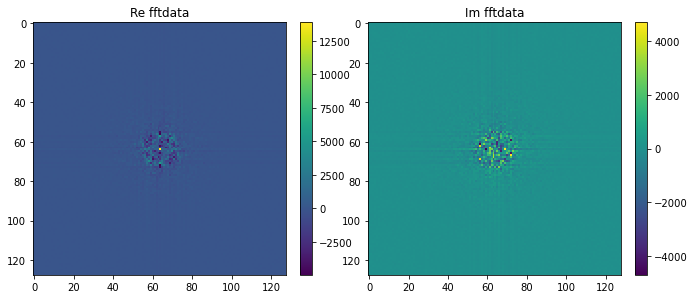

In [18]:
two_plots(dr, di, titles=['Re fftdata', 'Im fftdata'])

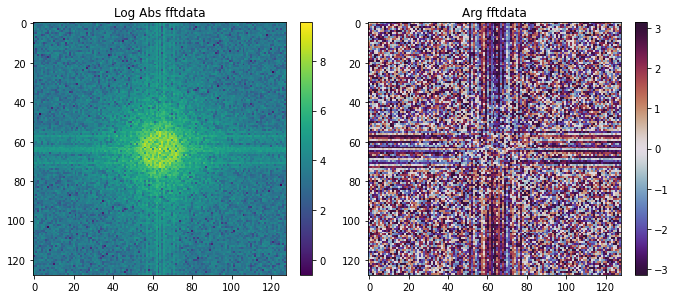

In [19]:
dabs, darg = np.abs(dat_fft), np.angle(dat_fft)
two_plots(np.log(dabs), darg, cmap=['viridis', 'twilight_shifted'], titles=['Log Abs fftdata', 'Arg fftdata'])

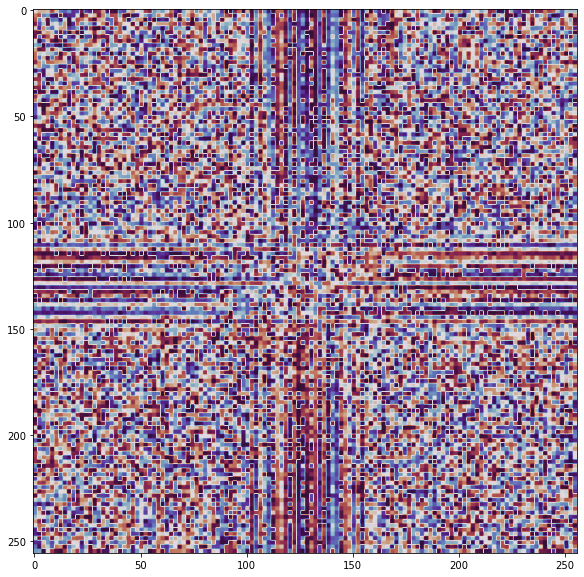

In [20]:
up = torch.nn.Upsample(scale_factor=2)
plt.figure(figsize=(10,10))
plt.imshow(up(torch.tensor(darg).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).numpy(), cmap='twilight_shifted')

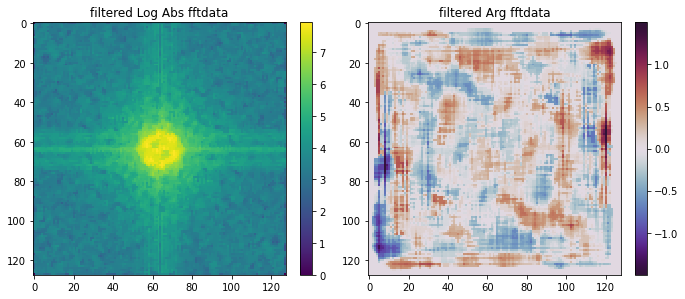

In [21]:
import scipy.signal
KERNEL_SIZE = 3
a1 = scipy.signal.medfilt2d(np.log(dabs), kernel_size=KERNEL_SIZE)
b1 = scipy.signal.medfilt2d(unroll(darg), kernel_size=11)
two_plots( a1, b1, cmap=['viridis', 'twilight_shifted'], titles=['filtered Log Abs fftdata', 'filtered Arg fftdata'])

Original
tensor(0.5959, device='cuda:0', dtype=torch.float64)


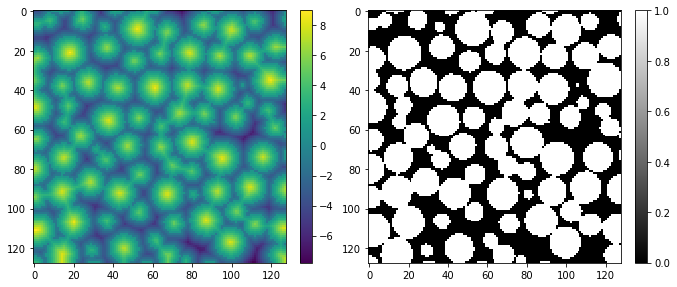

In [22]:
two_plots(dat.cpu(), data3d[selection].cpu(), cmap=['viridis', 'gray']);
print('Original')
print(torch.sum(data3d[selection]) / np.prod(data3d[selection].shape))

In [23]:
def reverse(a,b, unroll_a=True):
    if unroll_a:
        a = unroll(a)
    z = np.exp(a + 1j*b)
    return z


def sigmoid(x):
    return  1./(1. + np.exp(-x))

def lowrankify_r1(a1, fix_boundaries=True):
    a1 = torch.tensor(a1)
    u,s,v = torch.svd(a1)
    u = u[:, 0:1]
    v = v[:, 0:1]
    if fix_boundaries:
        K = (KERNEL_SIZE-1) //2
        u[:K,0] = u[K+1,0]
        u[-K:,0] = u[-K-1,0]
        v[:K,0] = v[K+1,0]
        v[-K:,0] = v[-K-1,0]
    
    return torch.matmul(u, v.T)*s[0]

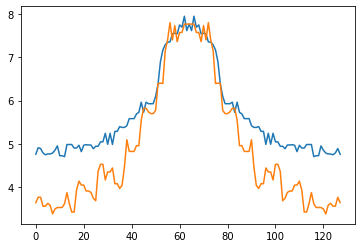

In [24]:
plt.plot(a1[data3d.shape[0]//2,:])
plt.plot(a1[:, data3d.shape[0]//2])

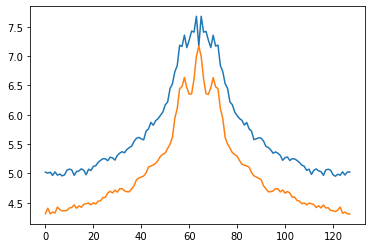

In [25]:
a2 = lowrankify_r1(a1)
plt.plot(a2[data3d.shape[0]//2,:])
plt.plot(a2[:, data3d.shape[0]//2])

<ipython-input-23-9fb08ba61fbe>:9: RuntimeWarning: overflow encountered in exp
  return  1./(1. + np.exp(-x))


FFT back and forth, but Absolute value filtered and put to Rank=1
0.5396348237991333


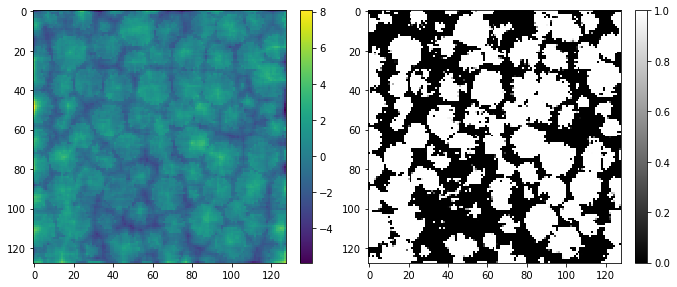

In [26]:
# plt.imshow(scipy.fft.ifftn(reverse(a1, unroll(darg))).real)

const = 0
d0 = const +  scipy.fft.ifftn(reverse(lowrankify_r1(a1), unroll(darg))).real 
two_plots(d0, sigmoid(100*(d0) ), cmap=['viridis', 'gray'])
print('FFT back and forth, but Absolute value filtered and put to Rank=1')
print(np.sum(sigmoid(10*(d0) )) / np.prod(sigmoid(d0).shape))

# Fitting 2D FFT

In [ ]:
from ipypb import ipb

In [27]:
N = data3d.shape[0]

re = torch.ones([N,N], requires_grad=True, device='cuda:0')
im = torch.ones([N,N], requires_grad=True, device='cuda:0')


# up = torch.nn.Upsample(scale_factor=2, mode='nearest').to(device)
L = torch.nn.MSELoss()

# L = torch.nn.BCELoss()

losses = []
lrs = [1e1, 1e0, 1e-1]
n_epochs = 1000
torch.autograd.set_detect_anomaly(True)
for lr in lrs:
    optimizer = torch.optim.Adam(params=[re, im], lr=lr)
    for epoch in ipb(range(n_epochs)):
#         im = up(im0.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        optimizer.zero_grad()
        spectrum = torch.stack([re,im], dim=-1)
        pic = torch.ifft(spectrum, signal_ndim=2)[...,0].double()
        loss = L(pic, data3d[selection])
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().
                      cpu())
        


 [████████████████████████████████████████████████████████████] 1000/1000 [00:08<00:00, 0.01s/it]

<ipython-input-27-9e524e8f293f>:22: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)
  pic = torch.ifft(spectrum, signal_ndim=2)[...,0].double()



 [████████████████████████████████████████████████████████████] 1000/1000 [00:08<00:00, 0.01s/it]


 [████████████████████████████████████████████████████████████] 1000/1000 [00:08<00:00, 0.01s/it]

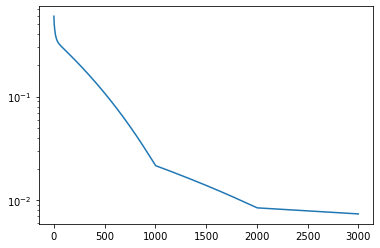

In [28]:
plt.semilogy(losses)

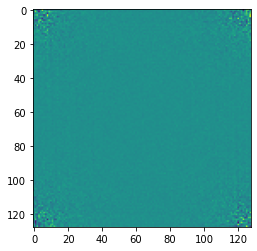

In [29]:
plt.imshow(spectrum[:,:,1].detach().cpu())

In [30]:
y = torch.view_as_complex(spectrum.detach().cpu())
# re, im = .T.detach().cpu()
# two_plots(re, im)

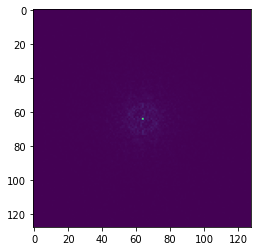

In [31]:
plt.imshow(torch.roll(y.abs(), shifts=(N//2,N//2), dims=(0,1)))

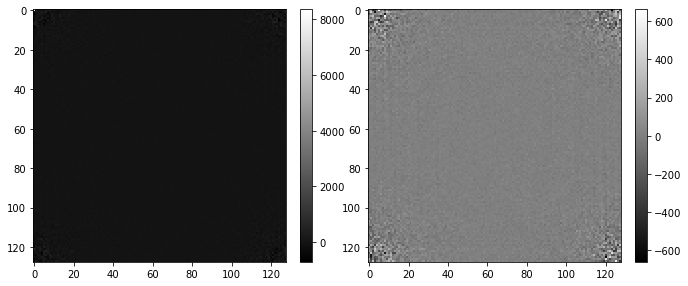

In [32]:
two_plots(y.real, y.imag, cmap=['gray', 'gray'])

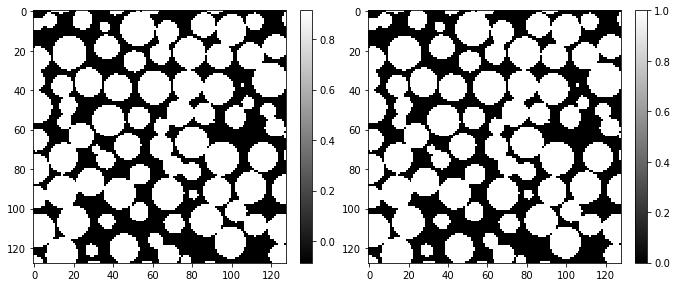

In [33]:
two_plots(pic.detach().cpu(), data3d[selection].detach().cpu(), cmap=['gray', 'gray'])

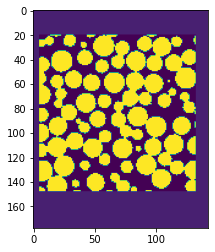

In [34]:
plt.imshow(torch.nn.functional.pad(pic, pad=[5,10,20,30], mode='constant', value=0).detach().cpu())

# Fitting rotationally-symmetric thingy

In [54]:
# центральная точка по координатам смещена в сторону увеличения индексов!

In [55]:
max_r = np.ceil(N/2*np.sqrt(2)).astype(int)
# uno = 1./(10+ torch.linspace(0, max_r, max_r, requires_grad=True, device='cuda:0', dtype=torch.double))


In [56]:
# plt.plot(uno.detach().cpu())

In [57]:
def roll_torch_2d(dat, N=None):
    if N is None:
        N = dat.shape[0]
    return torch.roll(dat, shifts=(N//2,N//2), dims=(0,1))
                      
def unroll_torch_2d(dat, N=None):
    if N is None:
        N = dat.shape[0]
    return torch.roll(dat, shifts=(-N//2,-N//2), dims=(0,1))
               


# plt.imshow(unroll_torch_2d(mapping))
# plt.colorbar()

In [58]:
xx, yy = torch.meshgrid([torch.linspace(-N//2,N//2-1, N)]*2) # memory bottleneck
mapping = torch.sqrt(xx**2 + yy**2) # memory bottleneck
addr = mapping.reshape(-1).round().clip(min=0,max=max_r-1).long()
del xx, yy, mapping

In [59]:
# plt.imshow(ans[:,:,0].detach().cpu().sigmoid())

In [60]:
# torch.max(mapping.reshape(-1,1))

In [63]:
y.abs().shape

torch.Size([128, 128])

In [64]:
N = data3d.shape[0]
L = torch.nn.MSELoss()
losses = []

max_r = np.ceil(N/2*np.sqrt(2)).astype(int)
uno = torch.zeros(max_r, requires_grad=True, device=device)

new_arg = torch.zeros((N,N),requires_grad=True, device=device)


lrs = [1e-1, 1e-2, 1e-3]
n_epochs = 200

for lr in lrs:
    optimizer = torch.optim.Adam(params=[uno, new_arg], lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        new_abs = torch.exp(unroll_torch_2d(uno[addr].reshape(N,N)))
        new_real = new_abs*torch.cos( new_arg.tanh()*np.pi)
        new_imag = new_abs*torch.sin( new_arg.tanh()*np.pi)
        new_spektrum = torch.stack([new_real, new_imag], dim=-1 )
        pic = torch.ifft(new_spektrum, signal_ndim=2)[:,:,0].double().sigmoid()
        
        
        loss = L(data3d[selection], pic)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().
                      cpu())
        

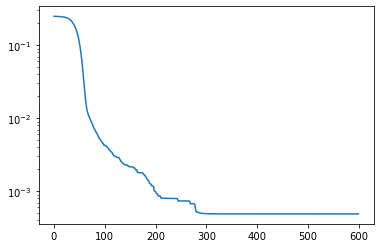

In [65]:
plt.semilogy(losses)

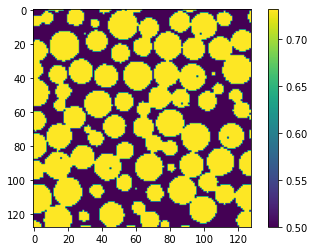

In [66]:
plt.imshow(pic.detach().cpu().sigmoid())
plt.colorbar()

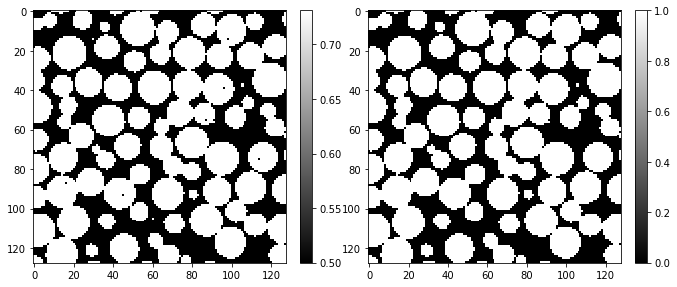

In [67]:
two_plots(pic.detach().cpu().sigmoid(), data3d[selection].detach().cpu(), cmap=['gray', 'gray'])

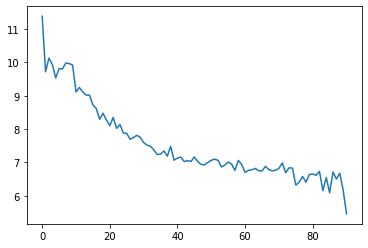

In [68]:
plt.plot(uno.detach().cpu())

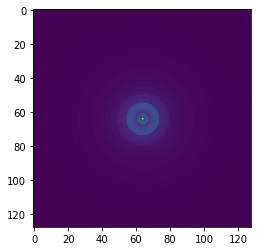

In [69]:
plt.imshow(roll_torch_2d(new_abs).cpu().detach())

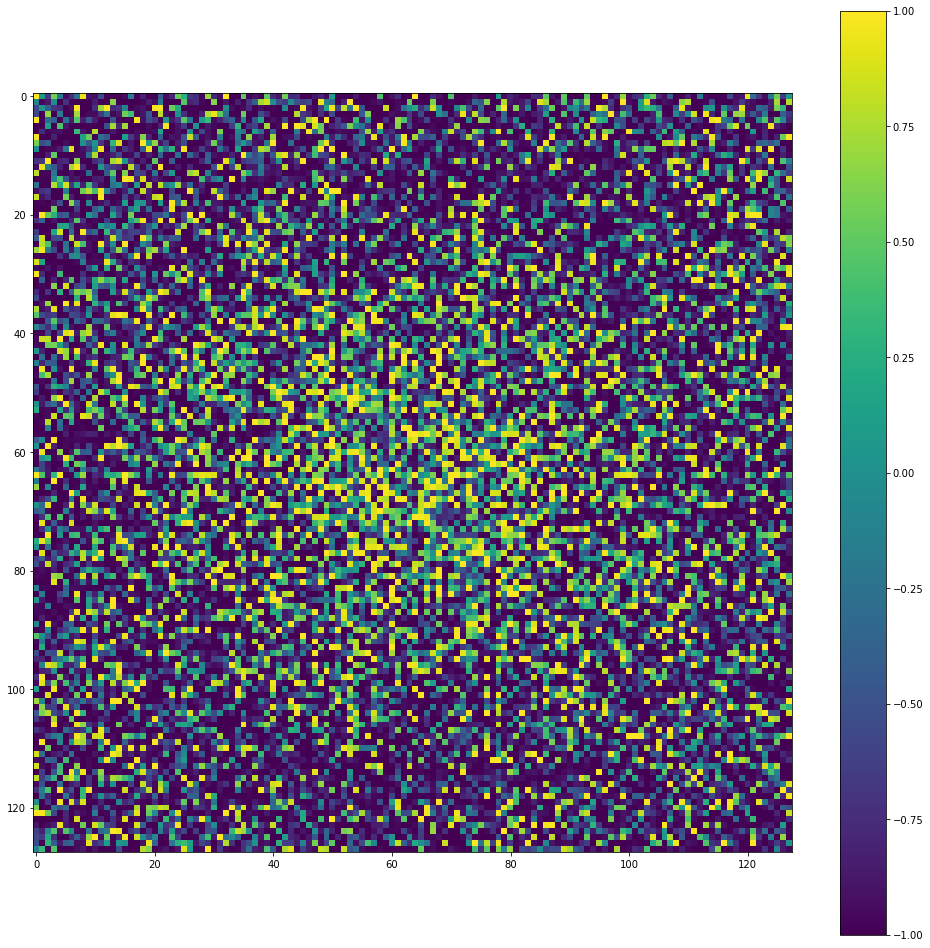

In [70]:
argus = roll_torch_2d(new_arg).cpu().detach()
# import scipy.signal
# KERNEL_SIZE = 3
# a1 = scipy.signal.medfilt2d(np.abs(argus) % (np.pi/2), kernel_size=KERNEL_SIZE)

plt.figure(figsize=(17,17))
plt.imshow((argus.tanh()*np.pi).cos(), cmap='viridis')
plt.colorbar()

In [71]:
argus

tensor([[ 0.0000,  0.5173,  0.9245,  ..., -0.3201, -0.9245, -0.5173],
        [ 0.5966,  1.5652, -1.1928,  ...,  0.2410,  2.1969,  0.2246],
        [ 0.8430, -0.5360, -0.7373,  ...,  0.3089, -0.4263, -4.3456],
        ...,
        [-0.8563, -0.9328,  0.4622,  ..., -3.3743,  0.2657, -2.4146],
        [-0.8430,  4.3456,  0.4263,  ..., -0.9205, -1.1959,  0.5362],
        [-0.5966, -0.4090, -2.1969,  ...,  0.5986,  1.1906, -1.5636]])

In [72]:
N

128

In [73]:
center = N//2

data = np.zeros([N**2, 2], dtype=float)

arg = ( torch.tensor(argus).tanh())*np.pi

i=0
for x in range(N):
    for y in range(N):
        
        r = np.sqrt((x-center)**2 + (y-center)**2)
        data[i,0] = r
        data[i,1] = arg[x,y]
        i += 1

<ipython-input-73-83b0fab765d1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arg = ( torch.tensor(argus).tanh())*np.pi


In [74]:
arg

tensor([[ 0.0000,  1.4942,  2.2872,  ..., -0.9726, -2.2872, -1.4942],
        [ 1.6796,  2.8785, -2.6121,  ...,  0.7429,  3.0649,  0.6941],
        [ 2.1595, -1.5393, -1.9714,  ...,  0.9406, -1.2635, -3.1405],
        ...,
        [-2.1814, -2.2993,  1.3569,  ..., -3.1342,  0.8157, -3.0918],
        [-2.1595,  3.1405,  1.2637,  ..., -2.2812, -2.6151,  1.5396],
        [-1.6796, -1.2176, -3.0649,  ...,  1.6840,  2.6099, -2.8777]])

(array([4004., 1519., 1037.,  904.,  793.,  777.,  854., 1041., 1498.,
        3957.]),
 array([-3.14141083, -2.51312866, -1.8848465 , -1.25656433, -0.62828217,
         0.        ,  0.62828217,  1.25656433,  1.8848465 ,  2.51312866,
         3.14141083]),
 <BarContainer object of 10 artists>)

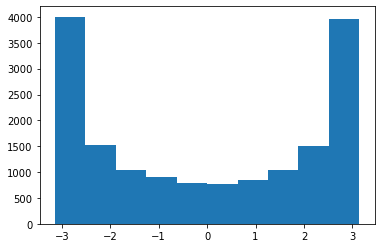

In [75]:
plt.hist(data[:,1])

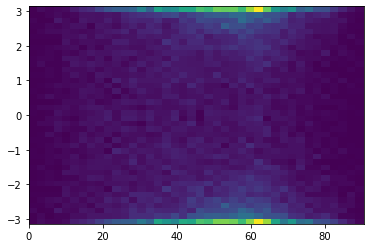

In [76]:
a= plt.hist2d(data[:,0], data[:,1], bins=40)

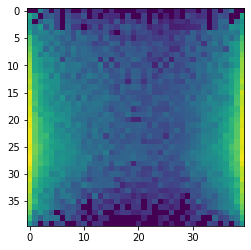

In [99]:
plt.imshow(np.log10(a[0] / a[0].sum(axis=1) + 1e-3)  )

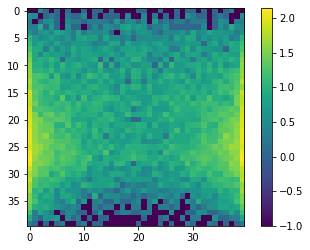

In [78]:
plt.imshow(np.log10(a[0] + 1e-1))
plt.colorbar()

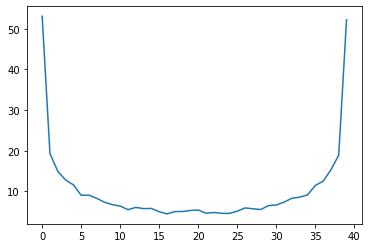

In [79]:
plt.plot(np.mean(a[0], axis=0))

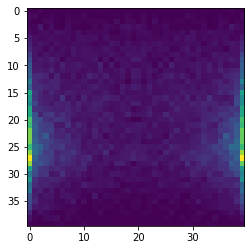

In [80]:
plt.imshow(a[0])

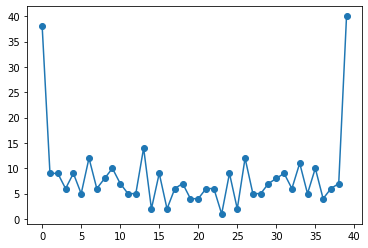

In [81]:
plt.plot(a[0][10], '-o')

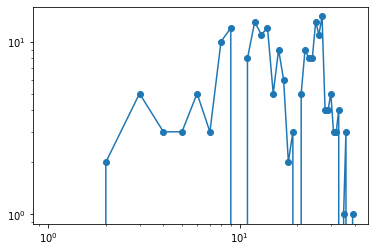

In [720]:
plt.loglog(a[0][:,0], '-o')

### Experiments with cutting out the tail of the abs curve

In [721]:
uno.detach()[uno<8] = 0

In [722]:
uno

tensor([11.3800,  9.7161, 10.1271,  9.9345,  9.5300,  9.8098,  9.8053,  9.9776,
         9.9627,  9.9181,  9.1142,  9.2470,  9.1109,  9.0187,  9.0170,  8.7198,
         8.6188,  8.2935,  8.4746,  8.2715,  8.1039,  8.3490,  8.0204,  8.1365,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000], device='cuda:0', requires_grad=True)

In [723]:
new_abs = torch.exp(unroll_torch_2d(uno[addr].reshape(N,N)))
new_real = new_abs*torch.cos( new_arg)
new_imag = new_abs*torch.sin( new_arg)
new_spektrum = torch.stack([new_real, new_imag], dim=-1 )
pic = torch.ifft(new_spektrum, signal_ndim=2)[:,:,0].double().sigmoid()

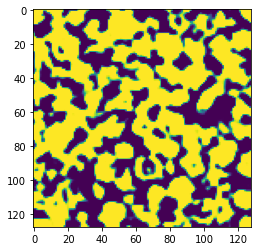

In [724]:
plt.imshow(pic.detach().cpu())